In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

# Import April Notebook

In [2]:
df = pd.read_csv('../data/raw/Mobi_System_Data_2022-04.csv')

In [3]:
df.head()

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
0,2022-05-01 0:00,2022-05-01 0:00,0217 Smithe & Burrard,0041 Cardero & Robson,365 Standard,1127.0,385,3963,4061,12,13,0,0
1,2022-05-01 0:00,2022-05-01 0:00,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),30 Day Pass,888.0,311,3919,4067,12,12,0,0
2,2022-05-01 0:00,2022-05-01 0:00,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),365 Standard,888.0,320,3897,4048,11,10,0,0
3,2022-05-01 0:00,2022-05-01 0:00,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2785.0,901,3932,3995,11,12,0,0
4,2022-05-01 0:00,2022-05-01 0:00,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2748.0,861,4077,4092,11,12,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53987 entries, 0 to 53986
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Departure                       53987 non-null  object 
 1   Return                          53955 non-null  object 
 2   Departure station               53987 non-null  object 
 3   Return station                  53950 non-null  object 
 4   Membership type                 53892 non-null  object 
 5   Covered distance (m)            53987 non-null  float64
 6   Duration (sec.)                 53987 non-null  int64  
 7   Departure battery voltage (mV)  53987 non-null  int64  
 8   Return battery voltage (mV)     53987 non-null  int64  
 9   Departure temperature (C)       53987 non-null  int64  
 10  Return temperature (C)          53987 non-null  int64  
 11  Stopover duration (sec.)        53987 non-null  int64  
 12  Number of stopovers             

With a quick glance from the info of our dataframe we can see that there is some null values that will need to be explored further

# Looking at Null/NA Values

In [5]:
# Find the percent per column of null values
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

Membership type                   0.175968
Return station                    0.068535
Return                            0.059274
Departure                         0.000000
Departure station                 0.000000
Covered distance (m)              0.000000
Duration (sec.)                   0.000000
Departure battery voltage (mV)    0.000000
Return battery voltage (mV)       0.000000
Departure temperature (C)         0.000000
Return temperature (C)            0.000000
Stopover duration (sec.)          0.000000
Number of stopovers               0.000000
dtype: float64

In [6]:
per_nan = (df.isnull().sum()/len(df)*100)[(df.isnull().sum()/len(df)*100) >0]

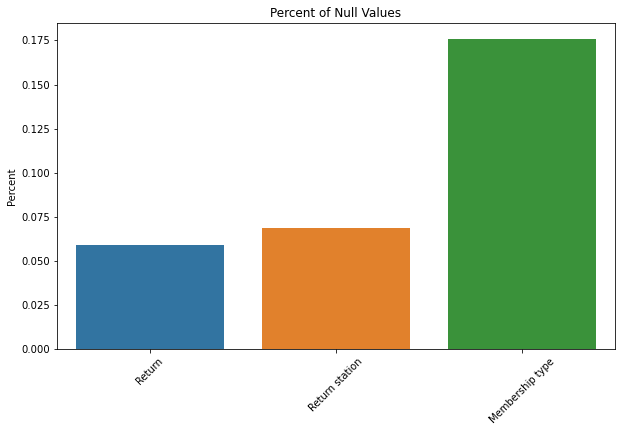

In [7]:
plt.figure(figsize=(10,6))
plt.title('Percent of Null Values')
plt.ylabel('Percent')
sns.barplot(x = per_nan.index, y = per_nan)
plt.xticks(rotation = 45)
plt.show()

## Looking at "Return" and "Return Station" null values

Logically a return time should also have a return station as they go hand in hand. However, from the missing values we can see that return stations has a slightly higher amount. Lets start off with understanding this column.

In [8]:
print(f"There are {len(df[df['Return station'].isnull()])} null values")
df[df['Return station'].isnull()].head()

There are 37 null values


,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
1158,2022-04-30 16:00,NaN,0015 Granville & Georgia,NaN,NaN,0.0,0,3814,0,15,0,0,0
11080,2022-04-25 21:00,NaN,0012 Dunsmuir & Richards,NaN,NaN,0.0,0,3689,0,13,0,0,0
20128,2022-04-22 14:00,NaN,0028 Davie & Beach,NaN,NaN,0.0,0,3595,0,19,0,0,0
20129,2022-04-22 14:00,NaN,0123 Georgia & Thurlow,NaN,NaN,0.0,0,4000,0,14,0,0,0
20919,2022-04-22 9:00,NaN,0137 Beach & Seymour,NaN,NaN,0.0,0,4009,0,12,0,0,0


It looks like half of the missing return stations are at the location of "Workshop." We will ignore these for now as we will handle them later on. 

Additionally, most of the return times are also missing which aligns with our initial assumption. However, there are a few return times without a return station.

Lets split the data into four groups: 
- Null values for both return and return station (Original dataframe)
- Workshop values
- Null value for only return station
- Null values for both - workshop values - return station values

In [9]:
# Null values for both return and return station
missing_return_station = df[df['Return station'].isnull()].copy()

In [10]:
# Missing workshop values
missing_workshop = missing_return_station[missing_return_station['Departure station'].str.contains('Workshop')].copy()

In [11]:
# Null value for only return station
missing_only_rs = missing_return_station[missing_return_station['Return'].notnull()].copy()

In [12]:
# Null values for both - workshop values - return station values
missing_remaining_return_station = missing_return_station[(~missing_return_station.index.isin(missing_only_rs.index))&\
                                                          (~missing_return_station.index.isin(missing_workshop.index))]
missing_remaining_return_station

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
1158,2022-04-30 16:00,NaN,0015 Granville & Georgia,NaN,NaN,0.0,0,3814,0,15,0,0,0
11080,2022-04-25 21:00,NaN,0012 Dunsmuir & Richards,NaN,NaN,0.0,0,3689,0,13,0,0,0
20128,2022-04-22 14:00,NaN,0028 Davie & Beach,NaN,NaN,0.0,0,3595,0,19,0,0,0
20129,2022-04-22 14:00,NaN,0123 Georgia & Thurlow,NaN,NaN,0.0,0,4000,0,14,0,0,0
20919,2022-04-22 9:00,NaN,0137 Beach & Seymour,NaN,NaN,0.0,0,4009,0,12,0,0,0
22903,2022-04-20 15:00,NaN,0044 Pacific & Richards,NaN,NaN,0.0,0,4113,0,18,0,0,0
23048,2022-04-20 14:00,NaN,0217 Smithe & Burrard,NaN,NaN,0.0,0,3864,0,19,0,0,0
23292,2022-04-20 12:00,NaN,0272 Pender & Victoria,NaN,NaN,0.0,0,3929,0,17,0,0,0
23710,2022-04-20 8:00,NaN,0089 Burrard & Drake,NaN,NaN,0.0,0,3835,0,8,0,0,0
28136,2022-04-17 6:00,NaN,0005 Dunsmuir & Beatty,NaN,NaN,0.0,0,3906,0,7,0,0,0


For this last dataframe of values that are null return station and return values without workshop departures we can see it represents a small portion of the total data only having 10 rows. 

There are two logical assumptions I am going to make:
1) Some of these bikes were rented and were still in use by the end of the month (April) and therefore will show up in the next month (May) returns.  
    - I will remove these rows as it will not benefit this analysis.  
    
2) Some of the bikes were rented but never retured. This could be due to a plethora of resasons some including, damaged or lost bikes, stolen bikes, and bikes that broke down during a ride and were brought to servicing.  
    - I will also remove these rows as it will not benefit this analysis and there are two few data points to draw conclusions from.  

In [13]:
df = df.drop(index = missing_remaining_return_station.index).copy()

Now lets check the dataframe that contained return times but didn't have a return location:

In [14]:
missing_only_rs

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
33075,2022-04-14 18:00,2022-04-22 11:00,0101 Stanley Park - Vancouver Aquarium,NaN,365 Corporate Plus Renewal,0.0,0,3819,0,14,0,0,0
33787,2022-04-14 14:00,2022-04-22 11:00,0189 Granville Island,NaN,24 Hour,0.0,0,3706,0,17,0,0,0
43107,2022-04-08 18:00,2022-04-09 10:00,0076 Cypress & 4th,NaN,365 Standard,0.0,0,3985,0,19,0,0,0
44821,2022-04-07 18:00,2022-04-14 12:00,0081 7th & Heather,NaN,365 Standard,0.0,0,3468,0,15,0,0,0
50215,2022-04-04 17:00,2022-04-05 15:00,0089 Burrard & Drake,NaN,365 Standard,0.0,0,3676,0,10,0,0,0


The assumption I am going to make here is the data that has been collected has either been corrupt or the bike/bike station has broken. This is because the other values associated with these rows are all 0 meaning that nothing else has been logged. This is not helpful for the analysis and we can drop these rows.

In [15]:
df = df.drop(index = missing_only_rs.index).copy()

Finally the missing values that have departed from a workshop location:

In [16]:
missing_workshop.head()

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
50396,2022-04-04 13:00,NaN,0981 Workshop - Service Complete,NaN,NaN,0.0,0,3715,0,22,0,0,0
50397,2022-04-04 13:00,NaN,0981 Workshop - Service Complete,NaN,NaN,0.0,0,3748,0,22,0,0,0
50435,2022-04-04 12:00,NaN,0981 Workshop - Service Complete,NaN,NaN,0.0,0,3744,0,23,0,0,0
50436,2022-04-04 12:00,NaN,0981 Workshop - Service Complete,NaN,NaN,0.0,0,3803,0,23,0,0,0
50437,2022-04-04 12:00,NaN,0981 Workshop - Service Complete,NaN,NaN,0.0,0,3690,0,22,0,0,0


Intuitively I think that departures or returns from a workshop location are actually servicable actions and are not performed by customers. Therefore, I am going to fill the null values with 0 for now so I can take a look at the workshop values as a whole later.

In [17]:
missing_workshop['Return'] = missing_workshop['Return'].fillna('None')
missing_workshop['Return station'] = missing_workshop['Return station'].fillna('None')
missing_workshop.head()

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
50396,2022-04-04 13:00,None,0981 Workshop - Service Complete,None,NaN,0.0,0,3715,0,22,0,0,0
50397,2022-04-04 13:00,None,0981 Workshop - Service Complete,None,NaN,0.0,0,3748,0,22,0,0,0
50435,2022-04-04 12:00,None,0981 Workshop - Service Complete,None,NaN,0.0,0,3744,0,23,0,0,0
50436,2022-04-04 12:00,None,0981 Workshop - Service Complete,None,NaN,0.0,0,3803,0,23,0,0,0
50437,2022-04-04 12:00,None,0981 Workshop - Service Complete,None,NaN,0.0,0,3690,0,22,0,0,0


In [18]:
df.loc[missing_workshop.index] = missing_workshop

Now lets visualize how many null values we have left:

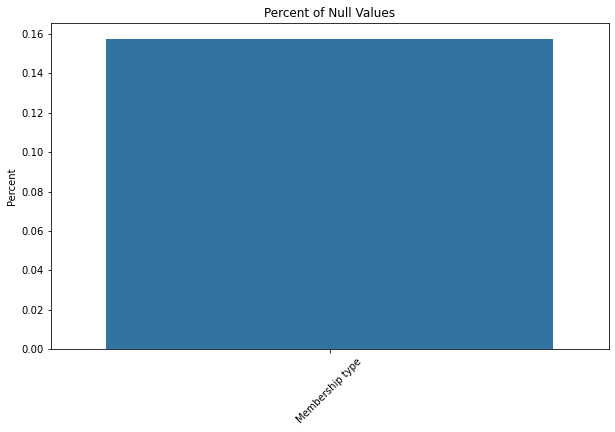

In [19]:
per_nan = (df.isnull().sum()/len(df)*100)[(df.isnull().sum()/len(df)*100) >0]

# Visualize the null values that are left
plt.figure(figsize=(10,6))
plt.title('Percent of Null Values')
plt.ylabel('Percent')
sns.barplot(x = per_nan.index, y = per_nan)
plt.xticks(rotation = 45)
plt.show()

Looks like all the null values for both return and return station were handled. Time to look at membership type. 

## Looking at "Membership type" null values

In [20]:
print(f"There are {len(df[df['Membership type'].isnull()])} null values")
df[df['Membership type'].isnull()].head()

There are 85 null values


,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
901,2022-04-30 18:00,2022-05-01 1:00,0218 Carrall & Seawall,0165 Columbia & 5th,NaN,1862.0,1033,0,3690,0,9,0,0
2011,2022-04-30 12:00,2022-04-30 17:00,0026 Beatty & Robson,0026 Beatty & Robson,NaN,85.0,588,0,3729,0,16,0,0
2057,2022-04-30 11:00,2022-04-30 18:00,0021 Cordova & Granville,0122 Haro & Denman,NaN,2915.0,1794,0,3853,0,14,0,0
3835,2022-04-29 14:00,2022-04-29 15:00,0014 Canada Place,0014 Canada Place,NaN,0.0,20,0,4076,0,15,0,0
4390,2022-04-29 11:00,2022-04-29 15:00,0052 Cambie & Water,0173 1st & Columbia,NaN,3461.0,1439,0,3774,0,18,0,0


In [21]:
missing_member = df[df['Membership type'].isnull()].copy()

Again let's filter all of the data that has a departure from a workshop location.

In [22]:
missing_member_nowork = missing_member[~missing_member['Departure station'].str.contains('Workshop')]
print(f"There are {len(missing_member_nowork)} null values")
missing_member_nowork.head()
# missing_member[missing_member['Return station'].str.contains('Workshop')]

There are 63 null values


,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
901,2022-04-30 18:00,2022-05-01 1:00,0218 Carrall & Seawall,0165 Columbia & 5th,NaN,1862.0,1033,0,3690,0,9,0,0
2011,2022-04-30 12:00,2022-04-30 17:00,0026 Beatty & Robson,0026 Beatty & Robson,NaN,85.0,588,0,3729,0,16,0,0
2057,2022-04-30 11:00,2022-04-30 18:00,0021 Cordova & Granville,0122 Haro & Denman,NaN,2915.0,1794,0,3853,0,14,0,0
3835,2022-04-29 14:00,2022-04-29 15:00,0014 Canada Place,0014 Canada Place,NaN,0.0,20,0,4076,0,15,0,0
4390,2022-04-29 11:00,2022-04-29 15:00,0052 Cambie & Water,0173 1st & Columbia,NaN,3461.0,1439,0,3774,0,18,0,0


In [23]:
missing_member_nowork.describe()

,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
count,63.000000,63.000000,63.0,63.000000,63.0,63.000000,63.000000,63.000000
mean,3420.857143,1666.079365,0.0,3906.190476,0.0,15.460317,5.301587,0.031746
std,2530.164363,1491.949788,0.0,180.564871,0.0,4.230555,29.939528,0.176731
min,0.000000,20.000000,0.0,3502.000000,0.0,3.000000,0.000000,0.000000
25%,2169.000000,927.000000,0.0,3750.000000,0.0,12.500000,0.000000,0.000000
50%,2893.000000,1294.000000,0.0,3898.000000,0.0,15.000000,0.000000,0.000000
75%,3835.500000,1674.500000,0.0,4020.000000,0.0,18.000000,0.000000,0.000000
max,13665.000000,7373.000000,0.0,4317.000000,0.0,24.000000,195.000000,1.000000


Looking at the dataframe and summary statistics it's hard to be confident in any patterns for why the membership type is not available. However, this could be due to the fact that departure battery and departure temperature are all 0 for this data. But what does this mean?  

- If someone rents a bike but the bike battery is dead does that have an impact?  
- Does departure temperature rely on the bike having a departure voltage?  
- How does someone continue to use the bike if it has no voltage to begin with?  

For now we will reclassify this data into a new column of "Unknown" instead of leaving as null values. This allows us to continue the analysis in the meantime. Additionally, since we are reclassifying and going to analyze workshop on its own, the values for workshop can also be changed.

In [24]:
missing_member.fillna('Unknown', inplace=True)

In [25]:
df.loc[missing_member.index] = missing_member

Time to check if we handled all of the missing values:

In [26]:
df.isnull().sum()

Departure                         0
Return                            0
Departure station                 0
Return station                    0
Membership type                   0
Covered distance (m)              0
Duration (sec.)                   0
Departure battery voltage (mV)    0
Return battery voltage (mV)       0
Departure temperature (C)         0
Return temperature (C)            0
Stopover duration (sec.)          0
Number of stopovers               0
dtype: int64

# Analysis of workshop departure/arrivals

My assumption is that all bike rides from or to a workshop station are from employees. However, we will need to explore this further.  

First lets check arrivals to a workshop location. This would mean that a bike would be at a normal station and be taken to a workshop location which aligns with the assumption that it will be serviced. 

In [52]:
workshop_departure = df[df['Departure station'].str.contains('Workshop')].copy()
workshop_departure['trip'] = 1
workshop_return = df[df['Return station'].str.contains('Workshop')].copy()
workshop_return['trip'] = 1

In [54]:
workshop_return.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 775 to 53852
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Departure                       83 non-null     object 
 1   Return                          83 non-null     object 
 2   Departure station               83 non-null     object 
 3   Return station                  83 non-null     object 
 4   Membership type                 83 non-null     object 
 5   Covered distance (m)            83 non-null     float64
 6   Duration (sec.)                 83 non-null     int64  
 7   Departure battery voltage (mV)  83 non-null     int64  
 8   Return battery voltage (mV)     83 non-null     int64  
 9   Departure temperature (C)       83 non-null     int64  
 10  Return temperature (C)          83 non-null     int64  
 11  Stopover duration (sec.)        83 non-null     int64  
 12  Number of stopovers             8

There are 83 records of workshop information for the arrival station. With domain knowledge of how some bikes are serviced I know that vans will park close to current bike stations and service through the back of their van. The assumption here is that rides with a "Covered distance (m)" less than 300m would be due to servicing as it is likely this is not a customer ride.

In [59]:
print(f'There are {len(workshop_return[workshop_return["Covered distance (m)"] < 300])} rows')
workshop_return[workshop_return['Covered distance (m)'] < 300]

There are 24 rows


,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers,trip
6642,2022-04-28 12:00,2022-04-28 12:00,0981 Workshop - Service Complete,0981 Workshop - Service Complete,VIP,0.0,40,3724,3750,23,22,0,0,1
6645,2022-04-28 12:00,2022-04-28 12:00,0981 Workshop - Service Complete,0981 Workshop - Service Complete,VIP,0.0,64,3761,3764,23,22,0,0,1
8948,2022-04-27 11:00,2022-04-27 11:00,0981 Workshop - Service Complete,0981 Workshop - Service Complete,Community Pass,20.0,255,3903,3945,22,19,0,0,1
9848,2022-04-26 18:00,2022-04-26 18:00,0997 Workshop - Demo Charging Station,0997 Workshop - Demo Charging Station,VIP,0.0,4,4771,4749,18,15,0,0,1
10060,2022-04-26 18:00,2022-04-27 19:00,0997 Workshop - Demo Charging Station,0997 Workshop - Demo Charging Station,VIP,70.0,89645,4715,4675,19,22,0,0,1
12007,2022-04-25 14:00,2022-04-25 14:00,0980 Workshop - Balancer Bike Check In,0997 Workshop - Demo Charging Station,VIP,0.0,48,4710,4714,19,16,0,0,1
12062,2022-04-25 14:00,2022-04-25 15:00,0222 Adanac & McLean,0982 Workshop - Bike Testing,VIP,228.0,5179,3586,3658,13,19,0,0,1
15526,2022-04-23 19:00,2022-04-23 19:00,0980 Workshop - Balancer Bike Check In,0980 Workshop - Balancer Bike Check In,VIP,103.0,83,4720,4677,19,22,0,0,1
18017,2022-04-23 11:00,2022-04-23 15:00,0177 Quebec & 1st,0994 Workshop - Testing,365 Day Founding Standard,0.0,0,3934,0,17,0,0,0,1
22055,2022-04-21 14:00,2022-04-21 15:00,1000 Temporary Events Station,0981 Workshop - Service Complete,VIP,20.0,2128,3776,3856,21,20,0,0,1


In [61]:
dfdf['Covered distance (m)'] <1

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
0,2022-05-01 0:00,2022-05-01 0:00,0217 Smithe & Burrard,0041 Cardero & Robson,365 Standard,1127.0,385,3963,4061,12,13,0,0
1,2022-05-01 0:00,2022-05-01 0:00,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),30 Day Pass,888.0,311,3919,4067,12,12,0,0
2,2022-05-01 0:00,2022-05-01 0:00,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),365 Standard,888.0,320,3897,4048,11,10,0,0
3,2022-05-01 0:00,2022-05-01 0:00,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2785.0,901,3932,3995,11,12,0,0
4,2022-05-01 0:00,2022-05-01 0:00,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2748.0,861,4077,4092,11,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53982,2022-04-01 0:00,2022-04-01 0:00,0064 Expo & Smithe,0053 Keefer & Abbott,365 Plus,741.0,219,3681,3861,9,10,0,0
53983,2022-04-01 0:00,2022-04-01 0:00,0083 Aquatic Centre,0148 Creekside Park North,24 Hour,3810.0,1580,3645,3795,8,7,0,0
53984,2022-04-01 0:00,2022-04-01 0:00,0212 Union & Dunlevy,0079 Nelson & Richards,365 Day Founding Standard,2329.0,623,3789,3980,7,8,0,0
53985,2022-04-01 0:00,2022-04-01 1:00,0019 Robson & Hornby,0030 Abbott & Cordova,365 Plus,1694.0,416,3732,3866,9,12,0,0


In [29]:
workshop_departure.groupby(['Departure station','Departure']).sum()

Covered distance (m)  \
Departure station                      Departure                                
0980 Workshop - Balancer Bike Check In 2022-04-02 12:00                 275.0   
                                       2022-04-04 12:00                   0.0   
                                       2022-04-08 13:00                1452.0   
                                       2022-04-10 13:00                6126.0   
                                       2022-04-23 19:00                 103.0   
                                       2022-04-25 14:00                   0.0   
0981 Workshop - Service Complete       2022-04-01 17:00                6203.0   
                                       2022-04-02 12:00                   2.0   
                                       2022-04-04 12:00                 777.0   
                                       2022-04-04 13:00                   0.0   
                                       2022-04-04 17:00                2254.0   
                                       2022-04-05 18:00                5427.0   
                                       2022-04-06 14:00                  22.0   
                                       2022-04-06 18:00                3040.0   
                                       2022-04-07 12:00                7148.0   
                                       2022-04-07 18:00                2666.0   
                                       2022-04-08 18:00               22348.0   
                                       2022-04-11 18:00                3444.0   
                                       2022-04-12 17:00                2268.0   
                                       2022-04-13 18:00                 412.0   
                                       2022-04-14 14:00                   0.0   
                                       2022-04-14 15:00                1970.0   
                                       2022-04-18 18:00                   0.0   
                                       2022-04-19 13:00                  37.0   
                                       2022-04-19 18:00                2233.0   
                                       2022-04-19 8:00                 4425.0   
                                       2022-04-20 13:00                  18.0   
                                       2022-04-20 14:00                2799.0   
                                       2022-04-20 18:00                3769.0   
                                       2022-04-21 14:00                  28.0   
                                       2022-04-21 17:00                2266.0   
                                       2022-04-21 18:00                2995.0   
                                       2022-04-22 10:00                 522.0   
                                       2022-04-22 12:00               19355.0   
                                       2022-04-22 17:00                3908.0   
                                       2022-04-25 13:00                 822.0   
                                       2022-04-25 17:00                2191.0   
                                       2022-04-26 13:00                 755.0   
                                       2022-04-26 17:00                2754.0   
                                       2022-04-27 10:00                2615.0   
                                       2022-04-27 11:00                  20.0   
                                       2022-04-28 12:00                   0.0   
                                       2022-04-28 14:00                1808.0   
                                       2022-04-29 15:00                 284.0   
                                       2022-04-29 17:00                2773.0   
0991 HQ Workshop                       2022-04-05 22:00                1245.0   
                                       2022-04-13 17:00                2086.0   
0994 Workshop - Testing                2022-04-15 12:00               10124.0   
       

In [315]:
workshop_departure

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
3025,2022-04-29 17:00,2022-04-29 17:00,0981 Workshop - Service Complete,0005 Dunsmuir & Beatty,VIP,2773.0,888,3737,3826,21,23,0,0
3559,2022-04-29 15:00,2022-04-29 15:00,0981 Workshop - Service Complete,0129 Richards & Robson,VIP,238.0,1321,4145,4177,23,21,0,0
3560,2022-04-29 15:00,2022-04-29 15:00,0981 Workshop - Service Complete,0129 Richards & Robson,VIP,46.0,1528,3610,3711,18,16,0,0
6345,2022-04-28 14:00,2022-04-28 14:00,0981 Workshop - Service Complete,0231 Napier & Commercial,VIP,900.0,820,3805,3831,22,21,291,1
6378,2022-04-28 14:00,2022-04-28 14:00,0997 Workshop - Demo Charging Station,0997 Workshop - Demo Charging Station,VIP,1177.0,1039,4776,4781,18,17,82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50459,2022-04-04 12:00,2022-04-04 12:00,0981 Workshop - Service Complete,0253 Charles & Woodland,VIP,694.0,195,3913,3972,22,23,0,0
50542,2022-04-04 12:00,2022-04-14 17:00,0981 Workshop - Service Complete,0980 Workshop - Balancer Bike Check In,VIP,83.0,881829,3939,3823,23,13,0,0
52127,2022-04-02 12:00,2022-04-02 12:00,0980 Workshop - Balancer Bike Check In,0981 Workshop - Service Complete,VIP,275.0,33,3719,3773,23,21,0,0
52128,2022-04-02 12:00,2022-04-02 12:00,0981 Workshop - Service Complete,0980 Workshop - Balancer Bike Check In,VIP,2.0,21,3724,3782,23,21,0,0


# time featuers

In [33]:
df['Departure'] = pd.to_datetime(df['Departure'], format = "%Y-%m-%d %H:%M%S")
df['Return'] = pd.to_datetime(df['Return'], format = "%Y-%m-%d %H:%M%S")

In [34]:
df.head()

,Departure,Return,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers
0,2022-05-01,2022-05-01,0217 Smithe & Burrard,0041 Cardero & Robson,365 Standard,1127.0,385,3963,4061,12,13,0,0
1,2022-05-01,2022-05-01,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),30 Day Pass,888.0,311,3919,4067,12,12,0,0
2,2022-05-01,2022-05-01,0037 Hornby & Nelson,0025 Homer & Robson (Vancouver Public Library),365 Standard,888.0,320,3897,4048,11,10,0,0
3,2022-05-01,2022-05-01,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2785.0,901,3932,3995,11,12,0,0
4,2022-05-01,2022-05-01,0028 Davie & Beach,0138 Richards & Helmcken,24 Hour,2748.0,861,4077,4092,11,12,0,0


#### How many stations are there?

In [115]:
# Departure Station
print(f'{len(df["Departure station"].value_counts())} stations were departed in April')

# Return Station
print(f'{len(df["Return station"].value_counts().index)} stations were returned in April')

205 stations were departed in April
206 stations were returned in April


This means there is a difference in stations that were departed and returned. So what is the correct total of stations? 

To answer this, I want to check if there is duplication due to a string error compared to a number errror. It seems like each station has a unique number combined with a string address. I will first compare the numbers by turning each column into a set and use symmetric_difference to return the values that are not matched

In [116]:
list_dep_stat_num = df.groupby('Departure station').sum().index.str.split(n = 1).tolist()
list_ret_stat_num = df.groupby('Return station').sum().index.str.split(n = 1).tolist()

# Returns values that are either in departure or return but not both
set([num[0] for num in list_dep_stat_num]).symmetric_difference(set([num[0] for num in list_ret_stat_num]))

{'0982'}

In [117]:
list_dep_stat_str = df.groupby('Departure station').sum().index.str.split(n = 1).tolist()
list_ret_stat_str = df.groupby('Return station').sum().index.str.split(n = 1).tolist()

# Returns values that are either in departure or return but not both
set([num[1] for num in list_dep_stat_str]).symmetric_difference(set([num[1] for num in list_ret_stat_str]))

{'Workshop - Bike Testing'}

It seems like the numeric values and strings both return only 1 mismatch which corresponds with a station called 'Workshop - Bike Testing'

In [134]:
df['Return station'][df['Return station'].str.contains('Workshop - Bike Testing')]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [126]:
df['Return station'][df['Return station'].str.contains('Workshop - Bike Testing')]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [112]:
len(set(df["Return station"].unique()).intersection(set(df["Return station"].value_counts().index)))

206

In [63]:
df["Departure station"][df["Departure station"].isin(df["Return station"])]

0        0217 Smithe & Burrard
1         0037 Hornby & Nelson
2         0037 Hornby & Nelson
3           0028 Davie & Beach
4           0028 Davie & Beach
                 ...          
53982       0064 Expo & Smithe
53983      0083 Aquatic Centre
53984     0212 Union & Dunlevy
53985     0019 Robson & Hornby
53986       0028 Davie & Beach
Name: Departure station, Length: 53987, dtype: object